# 4DIn12D

In [45]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import *
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

import numpy as np
from sklearn.preprocessing import LabelEncoder
from yellowbrick.features.radviz import RadViz
DIAMETER_METHODS = ['mean_cluster', 'farthest']
CLUSTER_DISTANCE_METHODS = ['nearest', 'farthest']

def inter_cluster_distances(labels, distances, method='nearest'):
    """Calculates the distances between the two nearest points of each cluster.
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param method: `nearest` for the distances between the two nearest points in each cluster, or `farthest`
    """
    if method not in CLUSTER_DISTANCE_METHODS:
        raise ValueError(
            'method must be one of {}'.format(CLUSTER_DISTANCE_METHODS))

    if method == 'nearest':
        return __cluster_distances_by_points(labels, distances)
    elif method == 'farthest':
        return __cluster_distances_by_points(labels, distances, farthest=True)


def __cluster_distances_by_points(labels, distances, farthest=False):
    n_unique_labels = len(np.unique(labels))
    cluster_distances = np.full((n_unique_labels, n_unique_labels),
                                float('inf') if not farthest else 0)

    np.fill_diagonal(cluster_distances, 0)

    for i in np.arange(0, len(labels) - 1):
        for ii in np.arange(i, len(labels)):
            if labels[i] != labels[ii] and (
                (not farthest and
                 distances[i, ii] < cluster_distances[labels[i], labels[ii]])
                    or
                (farthest and
                 distances[i, ii] > cluster_distances[labels[i], labels[ii]])):
                cluster_distances[labels[i], labels[ii]] = cluster_distances[
                    labels[ii], labels[i]] = distances[i, ii]
    return cluster_distances


def diameter(labels, distances, method='farthest'):
    """Calculates cluster diameters
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param method: either `mean_cluster` for the mean distance between all elements in each cluster, or `farthest` for the distance between the two points furthest from each other
    """
    if method not in DIAMETER_METHODS:
        raise ValueError('method must be one of {}'.format(DIAMETER_METHODS))

    n_clusters = len(np.unique(labels))
    diameters = np.zeros(n_clusters)

    if method == 'mean_cluster':
        for i in range(0, len(labels) - 1):
            for ii in range(i + 1, len(labels)):
                if labels[i] == labels[ii]:
                    diameters[labels[i]] += distances[i, ii]

        for i in range(len(diameters)):
            diameters[i] /= sum(labels == i)

    elif method == 'farthest':
        for i in range(0, len(labels) - 1):
            for ii in range(i + 1, len(labels)):
                if labels[i] == labels[ii] and distances[i, ii] > diameters[
                        labels[i]]:
                    diameters[labels[i]] = distances[i, ii]
    return diameters


def dunn(labels, distances, diameter_method='farthest',
         cdist_method='nearest'):
    """
    Dunn index for cluster validation (larger is better).
    
    .. math:: D = \\min_{i = 1 \\ldots n_c; j = i + 1\ldots n_c} \\left\\lbrace \\frac{d \\left( c_i,c_j \\right)}{\\max_{k = 1 \\ldots n_c} \\left(diam \\left(c_k \\right) \\right)} \\right\\rbrace
    
    where :math:`d(c_i,c_j)` represents the distance between
    clusters :math:`c_i` and :math:`c_j`, and :math:`diam(c_k)` is the diameter of cluster :math:`c_k`.
    Inter-cluster distance can be defined in many ways, such as the distance between cluster centroids or between their closest elements. Cluster diameter can be defined as the mean distance between all elements in the cluster, between all elements to the cluster centroid, or as the distance between the two furthest elements.
    The higher the value of the resulting Dunn index, the better the clustering
    result is considered, since higher values indicate that clusters are
    compact (small :math:`diam(c_k)`) and far apart (large :math:`d \\left( c_i,c_j \\right)`).
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param diameter_method: see :py:function:`diameter` `method` parameter
    :param cdist_method: see :py:function:`diameter` `method` parameter
    
    .. [Kovacs2005] Kovács, F., Legány, C., & Babos, A. (2005). Cluster validity measurement techniques. 6th International Symposium of Hungarian Researchers on Computational Intelligence.
    """

    labels = LabelEncoder().fit(labels).transform(labels)

    ic_distances = inter_cluster_distances(labels, distances, cdist_method)
    min_distance = min(ic_distances[ic_distances.nonzero()])
    max_diameter = max(diameter(labels, distances, diameter_method))

    return min_distance / max_diameter


In [46]:
import numpy as np
import pandas as pd
import sklearn.cluster as sc
import matplotlib.pyplot as mp

df=pd.read_csv("4DIn12D.csv")
df.head()

,labels,dim2,dim6,dim7,dim8,Name3Class
0,r155,0.314345,0.393007,0.044667,0.118493,3
1,r156,0.327695,0.410825,0.033796,0.070825,3
2,r157,0.316753,0.433747,0.054407,0.122989,3
3,r158,0.363791,0.399353,0.070283,0.097313,3
4,r159,0.320207,0.416929,0.066920,0.081252,3


In [47]:
x=df.iloc[:,1:-1]
y=df.iloc[:,-1]

In [48]:
# 均值漂移实现聚类划分

bw = sc.estimate_bandwidth(x, n_samples=len(x), quantile=0.2)
model = sc.MeanShift(bandwidth=bw)

model.fit(x)
centers = model.cluster_centers_
print(centers)
pred_y = model.predict(x)

[[0.33446171 0.39758833 0.07444329 0.07910476]
 [0.60301562 0.22273784 0.74762566 0.78930791]
 [0.91000036 0.80055592 0.07362254 0.08346961]
 [0.72607341 0.00129898 0.7066516  0.75453659]
 [0.21081142 0.01988992 0.74553331 0.82203023]
 [0.1981935  0.29306436 0.76030567 0.90897026]]


### 中间过程划分效果

In [49]:
d = euclidean_distances(x.iloc[:,0:4].values)
dunk = dunn(pred_y, d)
acc=accuracy_score(y,pred_y)
display(dunk)
display(acc)

0.38806703927315256

0.6

In [50]:
np.linspace(x["dim2"].values.min(),x["dim2"].values.max(),7)
[0.1981935 , 0.3213621 , 0.44453069, 0.56769928, 0.69086787, 0.81403646, 0.93720505]
haha=[]
for i in x["dim2"].values:
    if i>=0.1981935 and i <0.3213621:
        haha.append(0.1981935)
    elif i>=0.3213621 and i <0.44453069:
        haha.append(0.3213621)
    elif i>=0.44453069 and i <0.56769928:
        haha.append(0.44453069)
    elif i>=0.56769928 and i <0.69086787:
        haha.append(0.56769928)
    elif i>=0.69086787 and i <0.81403646:
        haha.append(0.69086787)
    elif i>=0.81403646 and i <=0.93720505:
        haha.append(0.81403646)

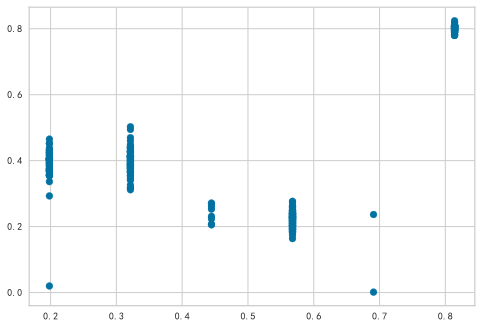

In [51]:
plt.scatter(haha, x["dim6"])

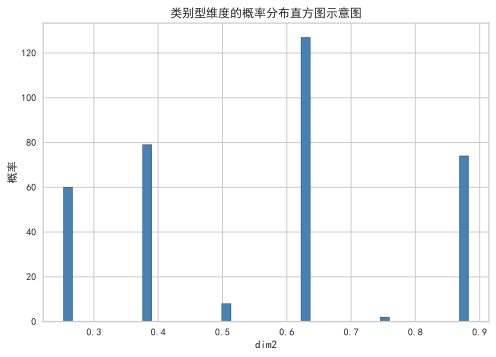

In [52]:
plt.rcParams["font.sans-serif"]='SimHei'
plt.rcParams['axes.unicode_minus']=False
%config InlineBackend.figure_format='svg'

plt.hist(x=x["dim2"],bins=6,rwidth=bw,
        color="steelblue",
        edgecolor="black")

#添加x轴和y轴标签
plt.xlabel("dim2")
plt.ylabel("概率")

#添加标题
plt.title("类别型维度的概率分布直方图示意图")

#显示图形
plt.show()

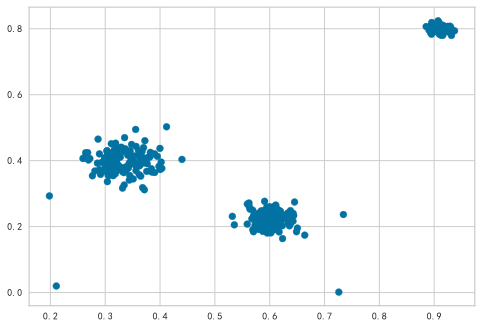

In [53]:
plt.scatter(x["dim2"], x["dim6"])

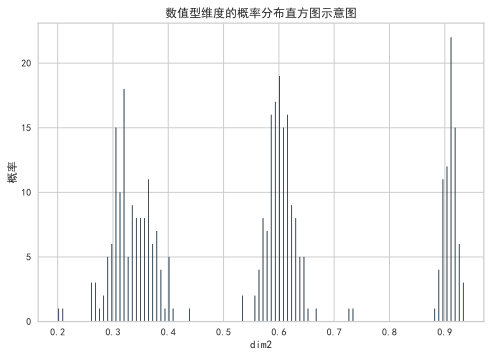

In [54]:
plt.rcParams["font.sans-serif"]='SimHei'
plt.rcParams['axes.unicode_minus']=False
%config InlineBackend.figure_format='svg'

plt.hist(x=x["dim2"],bins=100,rwidth=bw,
        color="steelblue",
        edgecolor="black")

#添加x轴和y轴标签
plt.xlabel("dim2")
plt.ylabel("概率")

#添加标题
plt.title("数值型维度的概率分布直方图示意图")

#显示图形
plt.show()

In [55]:
bw

0.11543317688437629

In [56]:
x["pred_y"]=pred_y

In [57]:
x=pd.merge(x,pd.get_dummies(x["pred_y"], prefix="expand"), left_index=True, right_index=True)
x=(x-x.min())/(x.max()-x.min())
x

,dim2,dim6,dim7,dim8,pred_y,expand_0,expand_1,expand_2,expand_3,expand_4,expand_5
0,0.157172,0.476087,0.028182,0.119516,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.175236,0.497742,0.016887,0.071436,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.160430,0.525603,0.038303,0.124051,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.224080,0.483800,0.054799,0.098153,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.165104,0.505161,0.051304,0.081954,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
345,0.602898,0.281886,0.773255,0.813337,0.2,0.0,1.0,0.0,0.0,0.0,0.0
346,0.589123,0.291132,0.824056,0.844943,0.2,0.0,1.0,0.0,0.0,0.0,0.0
347,0.601757,0.290078,0.936338,0.728159,0.2,0.0,1.0,0.0,0.0,0.0,0.0
348,0.544596,0.313879,0.724606,0.800907,0.2,0.0,1.0,0.0,0.0,0.0,0.0


## 原始计算

In [58]:
kmeans = KMeans(n_clusters=3)
k = kmeans.fit_predict(x.iloc[:,0:4].values,y)
d = euclidean_distances(x.iloc[:,0:4].values)
dunk = dunn(k, d)
acc=accuracy_score(y,k)

In [59]:
display(dunk)
display(acc)

0.9080528404189566

0.6085714285714285

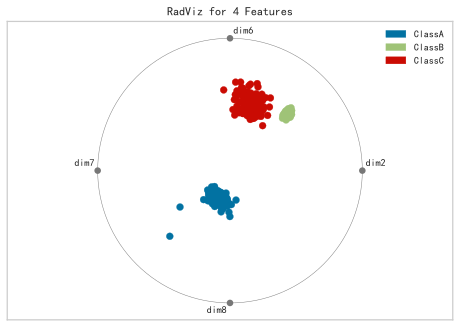

<AxesSubplot:title={'center':'RadViz for 4 Features'}>

In [60]:
features=["dim2","dim6","dim7","dim8"]
classes=["ClassA","ClassB","ClassC"]
visualizer = RadViz(classes= classes, features= features)
# Fit the data to the visualizer
visualizer.fit(x.iloc[:,0:4].values, y.values)
# Transform the data
visualizer.transform(x.iloc[:,0:4])
# Draw/show/poof the data
visualizer.poof()

## 加一个维度计算

0.7294044389779202

0.6085714285714285

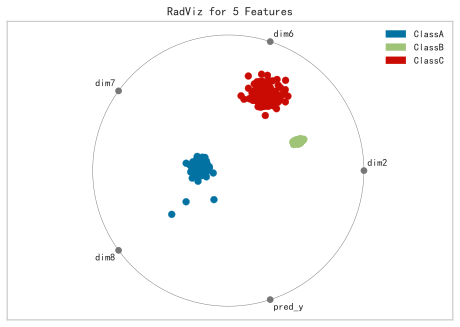

<AxesSubplot:title={'center':'RadViz for 5 Features'}>

In [61]:
kmeans = KMeans(n_clusters=3)
k = kmeans.fit_predict(x.iloc[:,0:5].values)
d = euclidean_distances(x.iloc[:,0:5].values)
dunk = dunn(k, d)
acc=accuracy_score(y,k)
display(dunk)
display(acc)
features=["dim2","dim6","dim7","dim8","pred_y"]
classes=["ClassA","ClassB","ClassC"]
visualizer = RadViz(classes= classes, features= features)
# Fit the data to the visualizer
visualizer.fit(x.iloc[:,0:5].values, y.values)
# Transform the data
visualizer.transform(x.iloc[:,0:5])
# Draw/show/poof the data
visualizer.poof()

# 加二值化维度计算

0.9779077599122492

0.21142857142857144

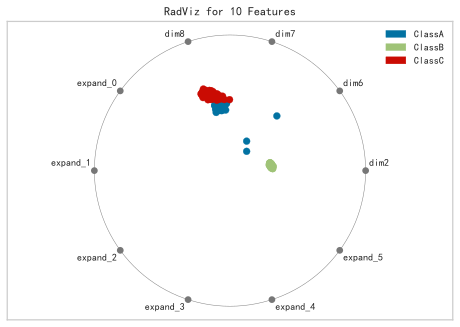

<AxesSubplot:title={'center':'RadViz for 10 Features'}>

In [62]:
kmeans = KMeans(n_clusters=3)
k = kmeans.fit_predict(x.drop(["pred_y"],axis=1).values)
d = euclidean_distances(x.drop(["pred_y"],axis=1).values)
dunk = dunn(k, d)
acc=accuracy_score(y,k)
display(dunk)
display(acc)
features=["dim2","dim6","dim7","dim8","expand_0","expand_1","expand_2","expand_3","expand_4","expand_5"]
classes=["ClassA","ClassB","ClassC"]
visualizer = RadViz(classes= classes, features= features)
# Fit the data to the visualizer
visualizer.fit(x.drop(["pred_y"],axis=1).values, y.values)
# Transform the data
visualizer.transform(x.drop(["pred_y"],axis=1))
# Draw/show/poof the data
visualizer.poof()

# 数据集iris

In [63]:
df=pd.read_csv("PaperData-软件学报-iris-normalization.csv")
df.head()

,id,col1,col2,col3,col4,className,classId
0,1,0.722,0.523,0.145,0.04,Iris-setosa,1
1,2,0.696,0.455,0.159,0.04,Iris-setosa,1
2,3,0.734,0.523,0.174,0.04,Iris-setosa,1
3,4,0.684,0.545,0.174,0.04,Iris-setosa,1
4,5,0.696,0.545,0.188,0.04,Iris-setosa,1


In [64]:
df=df.drop(["id","className"],axis=1)
df.head()

,col1,col2,col3,col4,classId
0,0.722,0.523,0.145,0.04,1
1,0.696,0.455,0.159,0.04,1
2,0.734,0.523,0.174,0.04,1
3,0.684,0.545,0.174,0.04,1
4,0.696,0.545,0.188,0.04,1


In [65]:
x=df.iloc[:,:-1]
y=df.iloc[:,-1]

In [66]:
# 均值漂移实现聚类划分

bw = sc.estimate_bandwidth(x, n_samples=len(x), quantile=0.2)
model = sc.MeanShift(bandwidth=bw)

model.fit(x)
centers = model.cluster_centers_
print(centers)
pred_y = model.predict(x)
x["pred_y"]=pred_y
x=pd.merge(x,pd.get_dummies(x["pred_y"], prefix="expand"), left_index=True, right_index=True)
x=(x-x.min())/(x.max()-x.min())
x

[[0.75920833 0.5894375  0.20997917 0.09333333]
 [0.74407143 0.69171429 0.62045238 0.52952381]
 [0.67017647 0.75544118 0.72082353 0.68117647]
 [0.8899     0.7682     0.8307     0.852     ]]


,col1,col2,col3,col4,pred_y,expand_0,expand_1,expand_2,expand_3
0,0.390351,0.124771,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0
1,0.333333,0.000000,0.016374,0.000000,0.0,1.0,0.0,0.0,0.0
2,0.416667,0.124771,0.033918,0.000000,0.0,1.0,0.0,0.0,0.0
3,0.307018,0.165138,0.033918,0.000000,0.0,1.0,0.0,0.0,0.0
4,0.333333,0.165138,0.050292,0.000000,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
145,0.945175,0.583486,0.915789,0.958333,1.0,0.0,0.0,0.0,1.0
146,0.083333,0.666055,0.949708,0.958333,1.0,0.0,0.0,0.0,1.0
147,0.140351,0.623853,0.966082,1.000000,1.0,0.0,0.0,0.0,1.0
148,0.195175,0.708257,0.966082,1.000000,1.0,0.0,0.0,0.0,1.0


### 中间过程划分效果

In [67]:
d = euclidean_distances(x.iloc[:,0:4].values)
dunk = dunn(pred_y, d)
acc=accuracy_score(y,pred_y)
display(dunk)
display(acc)

0.048644048677282045

0.19333333333333333

In [68]:
np.linspace(x["col1"].values.min(),x["col1"].values.max(),5)

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [69]:
[0.  , 0.25, 0.5 , 0.75, 1.  ]
haha=[]
for i in x["col1"].values:
    if i>=0 and i <0.25:
        haha.append(0.1)
    elif i>=0.25 and i <0.5:
        haha.append(0.4)
    elif i>=0.5 and i <0.75:
        haha.append(0.6)
    elif i>=0.75 and i <=1:
        haha.append(0.9)

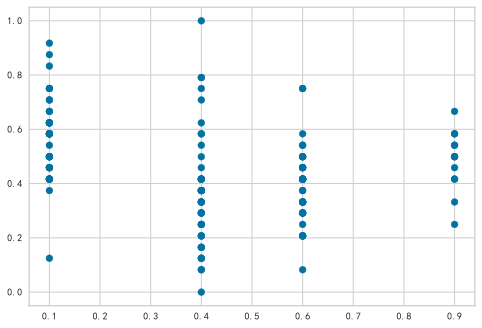

In [70]:
plt.scatter(haha, x["col2"])

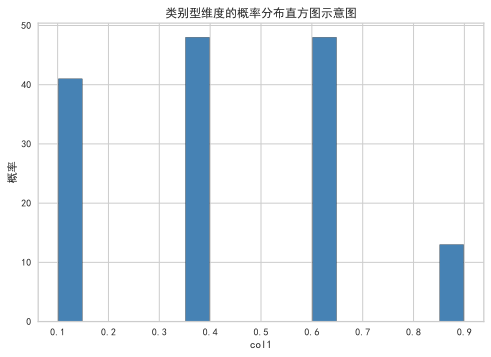

In [71]:
plt.rcParams["font.sans-serif"]='SimHei'
plt.rcParams['axes.unicode_minus']=False
%config InlineBackend.figure_format='svg'

plt.hist(x=x["col1"],bins=4,rwidth=bw,
        color="steelblue",
        edgecolor="black")

#添加x轴和y轴标签
plt.xlabel("col1")
plt.ylabel("概率")

#添加标题
plt.title("类别型维度的概率分布直方图示意图")

#显示图形
plt.show()

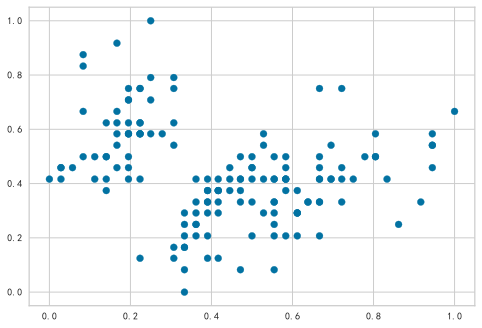

In [72]:
plt.scatter(x["col1"], x["col2"])

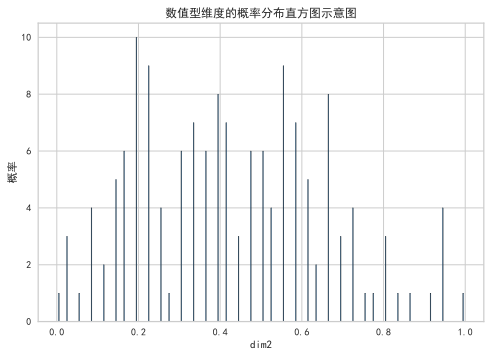

In [73]:
plt.rcParams["font.sans-serif"]='SimHei'
plt.rcParams['axes.unicode_minus']=False
%config InlineBackend.figure_format='svg'

plt.hist(x=x["col1"],bins=100,rwidth=bw,
        color="steelblue",
        edgecolor="black")

#添加x轴和y轴标签
plt.xlabel("dim2")
plt.ylabel("概率")

#添加标题
plt.title("数值型维度的概率分布直方图示意图")

#显示图形
plt.show()

# 原始计算

0.14241923463211803

0.43333333333333335

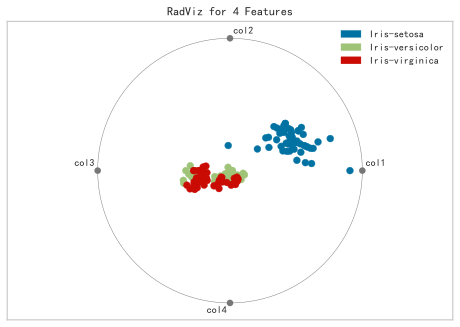

<AxesSubplot:title={'center':'RadViz for 4 Features'}>

In [74]:
kmeans = KMeans(n_clusters=3)
k = kmeans.fit_predict(x.iloc[:,0:4].values)
d = euclidean_distances(x.iloc[:,0:4].values)
dunk = dunn(k, d)
acc=accuracy_score(y,k)
display(dunk)
display(acc)
features=["col1","col2","col3","col4"]
classes=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
visualizer = RadViz(classes= classes, features= features)
# Fit the data to the visualizer
visualizer.fit(x.iloc[:,0:4].values, y.values)
# Transform the data
visualizer.transform(x.iloc[:,0:4])
# Draw/show/poof the data
visualizer.poof()

# 加一个维度计算

0.30880743709932656

0.04

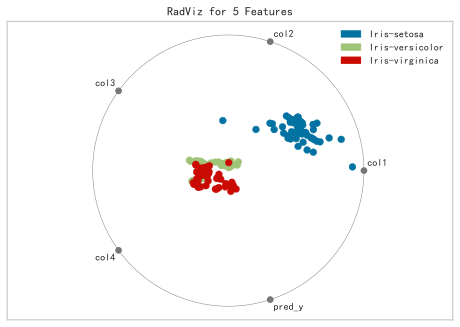

<AxesSubplot:title={'center':'RadViz for 5 Features'}>

In [75]:
kmeans = KMeans(n_clusters=3)
k = kmeans.fit_predict(x.iloc[:,0:5].values)
d = euclidean_distances(x.iloc[:,0:5].values)
dunk = dunn(k, d)
acc=accuracy_score(y,k)
display(dunk)
display(acc)
features=["col1","col2","col3","col4","pred_y"]
classes=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
visualizer = RadViz(classes= classes, features= features)
# Fit the data to the visualizer
visualizer.fit(x.iloc[:,0:5].values, y.values)
# Transform the data
visualizer.transform(x.iloc[:,0:5])
# Draw/show/poof the data
visualizer.poof()

# 加二值化维度计算

0.7994737291087812

0.04

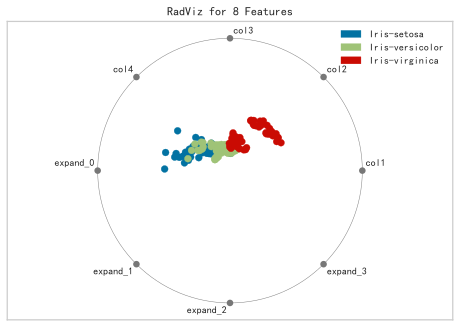

<AxesSubplot:title={'center':'RadViz for 8 Features'}>

In [76]:
kmeans = KMeans(n_clusters=3)
k = kmeans.fit_predict(x.drop(["pred_y"],axis=1).values)
d = euclidean_distances(x.drop(["pred_y"],axis=1).values)
dunk = dunn(k, d)
acc=accuracy_score(y,k)
display(dunk)
display(acc)
features=["col1","col2","col3","col4","expand_0","expand_1","expand_2","expand_3"]
classes=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
visualizer = RadViz(classes= classes, features= features)
# Fit the data to the visualizer
visualizer.fit(x.drop(["pred_y"],axis=1).values, y.values)
# Transform the data
visualizer.transform(x.drop(["pred_y"],axis=1))
# Draw/show/poof the data
visualizer.poof()